# Single-objective and Multi-objective Bayesian optimization for a retention modelling toy example

In this tutorial, we illustrate how to implement the single-objective and multi-objective BO algorithms. It closely follows the toy retention modelling experiment shown in Section 4.5 of [Closed-loop automatic gradient design for liquid chromatography using Bayesian optimization](https://chemrxiv.org/engage/chemrxiv/article-details/62e2a383e7fc8f9e388caabc). 

Here we are using the [BoFire](https://github.com/experimental-design/bofire) library for the optimization:

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple


from rm_code.crf import capped_sum_of_resolutions
from rm_code.retention_model import compute_chromatogram
from rm_code.plot_chromatogram import plot_chromatogram


from bofire.data_models.domain.api import Domain, Inputs, Outputs, Constraints
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput
from bofire.data_models.constraints.api import LinearInequalityConstraint
from bofire.benchmarks.api import Benchmark
from bofire.data_models.objectives.api import MaximizeObjective, MinimizeObjective
from bofire.data_models.strategies.api import RandomStrategy, SoboStrategy, MoboStrategy
import bofire.strategies.api as strategies
from bofire.runners.api import run
from bofire.utils.multiobjective import compute_hypervolume, get_pareto_front



/Users/jimboelrijk/opt/anaconda3/envs/bofire/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jimboelrijk/opt/anaconda3/envs/bofire/lib/python3.11/site-packages/bofire/surrogates/xgb.py:12: UserWarning: xgboost not installed, BoFire's `XGBoostSurrogate` cannot be used.
  warnings.warn("xgboost not installed, BoFire's `XGBoostSurrogate` cannot be used.")


In [27]:
class HPLC(Benchmark):

    def __init__(self, n_gradients, multiobjective = False):
        super().__init__(outlier_rate=0, outlier_prior=None)
        self.n_gradients = n_gradients
        outputs = [ContinuousOutput(key="resolution", objective=MaximizeObjective())]
        if multiobjective:
            outputs.append(ContinuousOutput(key="ctime", objective=MinimizeObjective()))
        self._domain = Domain(
            inputs=Inputs(
                features=[ContinuousInput(key=f"t_{i+1}", bounds=(0.01, 59.9)) for i in range(n_gradients)]+[ContinuousInput(key=f"phi_{i+1}", bounds=(0.01, 1)) for i in range(n_gradients)]
            ),
            constraints=Constraints(
                constraints=
                    [LinearInequalityConstraint(features=[f"t_{i+2}",f"t_{i+1}"], coefficients=[-1.,1.], rhs=-0.01) for i in range(n_gradients-1)]+[LinearInequalityConstraint(features=[f"phi_{i+2}",f"phi_{i+1}"], coefficients=[-1.,1.], rhs=0) for i in range(n_gradients-1)],
            ),
            outputs=Outputs(
                features=outputs,
            )
        )
        
        ret_pars = np.loadtxt('data/RetentionParams_Section4.5.txt') # retention parameters from example in Section 4.5
        self.k0_list = np.exp(ret_pars[:,0])
        self.S_list = ret_pars[:,1]
        # Set some default parameters
        self.t_0 = 0.8 # dead time 
        self.t_D = 0.8 # dwell time
        self.N = 1000 # plate number
        self.t_init = 0 # init time

    @property
    def ts(self) -> List[str]:
        return [f"t_{i+1}"for i in range(self.n_gradients)]
    
    @property
    def phis(self) -> List[str]:
        return [f"phi_{i+1}"for i in range(self.n_gradients)]
    
    def plot_chromatogram(self, candidate:pd.Series):
        phi_list_ms = [0.0] + candidate[self.phis].tolist() + [1.0]
        t_list_ms = [0.0] + candidate[self.ts].tolist() + [60.0]
        tR_list, W_list = compute_chromatogram(self.k0_list, self.S_list, self.t_0, self.t_D, self.t_init, phi_list_ms, t_list_ms, self.N)
        score_lin = capped_sum_of_resolutions(tR_list, W_list, max_time=60, min_res=0, max_res=1.5)
        # compute time score, i.e. time of last eluting peak.
        time_score_lin = np.max(tR_list)
        plot_chromatogram(tR_list, W_list, phi_list_ms, t_list_ms, self.t_D, self.t_0, self.t_init)
        print(f"resolution: {score_lin}")
        print(f"time: {time_score_lin}")
        return score_lin, time_score_lin


    def _f(self, candidates: pd.DataFrame) -> pd.DataFrame:
        data = {
            "resolution": [],
            "valid_resolution": [],
            "ctime": [],
            "valid_ctime": [],
        }
        for i, row in candidates.iterrows():
            phi_list_ms = [0.0] + row[self.phis].tolist() + [1.0]
            t_list_ms = [0.0] + row[self.ts].tolist() + [60.0]
            #print(phi_list_ms)
            #print(t_list_ms)
            tR_list, W_list = compute_chromatogram(self.k0_list, self.S_list, self.t_0, self.t_D, self.t_init, phi_list_ms, t_list_ms, self.N)
            score_lin = capped_sum_of_resolutions(tR_list, W_list, max_time=60, min_res=0, max_res=1.5)
            # compute time score, i.e. time of last eluting peak.
            time_score_lin = np.max(tR_list)
            data["resolution"].append(score_lin)
            data["valid_resolution"].append(1)
            data["ctime"].append(time_score_lin)
            data["valid_ctime"].append(1)
        return pd.DataFrame.from_dict(data=data)

### Alternative Relative Coordinate system

Attempting alternative coordinate system, in case you have 4 gradient nodes to position (8 degrees of freedom in total), you could setup all ts and phis as reduced ts_r and phis_r with ranges from 0 to 1. The time of the first gradient point would be just t_1 = lower_bound + t_1r * (upper_bound – lower_bound), the time of the second gradient would then be determined by the position of the first one and the upper bound: t_2 = t_1 + t_2r * (upper_bound – t1). This can then be applied for the timings of all gradients and for the phis.

In [75]:
class HPLC_alt(Benchmark):

    def __init__(self, n_gradients, multiobjective = False):
        super().__init__(outlier_rate=0, outlier_prior=None)
        self.n_gradients = n_gradients
        outputs = [ContinuousOutput(key="resolution", objective=MaximizeObjective())]
        if multiobjective:
            outputs.append(ContinuousOutput(key="ctime", objective=MinimizeObjective()))
        self._domain = Domain(
            inputs=Inputs(
                features=[ContinuousInput(key=f"t_{i+1}", bounds=(0.01, 0.99)) for i in range(n_gradients)]+[ContinuousInput(key=f"phi_{i+1}", bounds=(0.01, 0.99)) for i in range(n_gradients)]
            ),
            # constraints=Constraints(
            #     constraints=
            #         [LinearInequalityConstraint(features=[f"t_{i+2}",f"t_{i+1}"], coefficients=[-1.,1.], rhs=-0.01) for i in range(n_gradients-1)]+[LinearInequalityConstraint(features=[f"phi_{i+2}",f"phi_{i+1}"], coefficients=[-1.,1.], rhs=0) for i in range(n_gradients-1)],
            # ),
            outputs=Outputs(
                features=outputs,
            )
        )
        
        ret_pars = np.loadtxt('data/RetentionParams_Section4.5.txt') # retention parameters from example in Section 4.5
        self.k0_list = np.exp(ret_pars[:,0])
        self.S_list = ret_pars[:,1]
        # Set some default parameters
        self.t_0 = 0.8 # dead time 
        self.t_D = 0.8 # dwell time
        self.N = 1000 # plate number
        self.t_init = 0 # init time
        self.max_time = 60 # max time

    @property
    def ts(self) -> List[str]:
        return [f"t_{i+1}"for i in range(self.n_gradients)]
    
    @property
    def phis(self) -> List[str]:
        return [f"phi_{i+1}"for i in range(self.n_gradients)]
    
    def plot_chromatogram(self, candidate:pd.Series):
        phis, ts = self.transform(candidate[self.phis].tolist(), candidate[self.ts].tolist())
        phi_list_ms = [0.0] + phis + [1.0]
        t_list_ms = [0.0] + ts + [60.0]      

        print(t_list_ms, phi_list_ms)
        tR_list, W_list = compute_chromatogram(self.k0_list, self.S_list, self.t_0, self.t_D, self.t_init, phi_list_ms, t_list_ms, self.N)
        score_lin = capped_sum_of_resolutions(tR_list, W_list, max_time=60, min_res=0, max_res=1.5)
        # compute time score, i.e. time of last eluting peak.
        time_score_lin = np.max(tR_list)
        plot_chromatogram(tR_list, W_list, phi_list_ms, t_list_ms, self.t_D, self.t_0, self.t_init)
        print(f"resolution: {score_lin}")
        print(f"time: {time_score_lin}")
        return score_lin, time_score_lin

    def transform(self, phis_r: List[float], ts_r: List[float]) -> [List[float], List[float]]:
        lower_bound_t = 0
        upper_bound_t = 1
        lower_bound_phi = 0
        upper_bound_phi = 1
        ts = []
        phis = []
        for phi_r, t_r in zip(phis_r, ts_r):
            t = lower_bound_t + (t_r * (upper_bound_t - lower_bound_t))
            lower_bound_t = t
            ts.append(t)
            phi = lower_bound_phi + (phi_r * (upper_bound_phi - lower_bound_phi))
            phis.append(phi)
            lower_bound_phi =phi

        # RM code does not like similar timepoints, will cause a divide by zero.
        for i in range(len(ts) - 1):
            if ts[i + 1] - ts[i] < 0.01:
                for j in range(i + 1, len(ts)):
                    ts[j] = ts[j] + 0.01

        return phis, [t * self.max_time for t in ts]
        
    
    def _f(self, candidates: pd.DataFrame) -> pd.DataFrame:
        data = {
            "resolution": [],
            "valid_resolution": [],
            "ctime": [],
            "valid_ctime": [],
        }
        for i, row in candidates.iterrows():
            phis, ts = self.transform(row[self.phis].tolist(), row[self.ts].tolist())
            phi_list_ms = [0.0] + phis + [1.0]
            t_list_ms = [0.0] + ts + [60.0]      
            
            # print(phi_list_ms)
            # print(t_list_ms)
            tR_list, W_list = compute_chromatogram(self.k0_list, self.S_list, self.t_0, self.t_D, self.t_init, phi_list_ms, t_list_ms, self.N)
            score_lin = capped_sum_of_resolutions(tR_list, W_list, max_time=60, min_res=0, max_res=1.5)
            # compute time score, i.e. time of last eluting peak.
            time_score_lin = np.max(tR_list)
            data["resolution"].append(score_lin)
            data["valid_resolution"].append(1)
            data["ctime"].append(time_score_lin)
            data["valid_ctime"].append(1)
        return pd.DataFrame.from_dict(data=data)


## Perform random sampling to show that constraints are accepted.

In [80]:
hplc_alt = HPLC_alt(n_gradients=4)

strategy_data = RandomStrategy(domain=hplc_alt.domain)
sampler = strategies.map(strategy_data)
candidates = sampler.ask(5)
experiments = hplc_alt.f(candidates=candidates, return_complete=True)
display(experiments)

,phi_1,phi_2,phi_3,phi_4,t_1,t_2,t_3,t_4,resolution,valid_resolution,ctime,valid_ctime
0,0.827182,0.176433,0.047486,0.368238,0.489581,0.769864,0.251683,0.406656,12.882466,1,50.958135,1
1,0.120225,0.802031,0.055111,0.938640,0.189442,0.926826,0.938538,0.586519,8.895547,1,65.927543,1
2,0.301246,0.822149,0.914842,0.652782,0.708216,0.124670,0.935947,0.778993,12.185555,1,58.923733,1
3,0.555444,0.225796,0.961184,0.306364,0.140402,0.862721,0.227888,0.383318,12.099054,1,60.855417,1
4,0.682976,0.587560,0.043096,0.410027,0.043271,0.286102,0.161412,0.917606,10.990216,1,30.938572,1


## Perform random sampling to show that constraints are accepted.

In [81]:
hplc = HPLC(n_gradients=4)

strategy_data = RandomStrategy(domain=hplc.domain)
sampler = strategies.map(strategy_data)
candidates = sampler.ask(5)
experiments = hplc.f(candidates=candidates, return_complete=True)
display(experiments)

,phi_1,phi_2,phi_3,phi_4,t_1,t_2,t_3,t_4,resolution,valid_resolution,ctime,valid_ctime
0,0.399266,0.611223,0.818326,0.920101,24.027721,31.723141,32.118410,44.704480,12.559709,1,50.172250,1
1,0.028144,0.063306,0.302554,0.539547,2.958935,33.955204,40.486797,48.016454,7.806258,1,65.913878,1
2,0.019281,0.293427,0.403945,0.483135,14.237077,32.222386,35.254138,48.715366,7.798876,1,66.243287,1
3,0.226030,0.327853,0.420438,0.482411,13.878148,24.231655,36.990466,49.198114,8.001205,1,66.179068,1
4,0.180979,0.435504,0.491831,0.673009,10.346447,17.716038,44.318734,57.044332,8.322746,1,66.920368,1


## Handpicked gradient program to serve as baseline

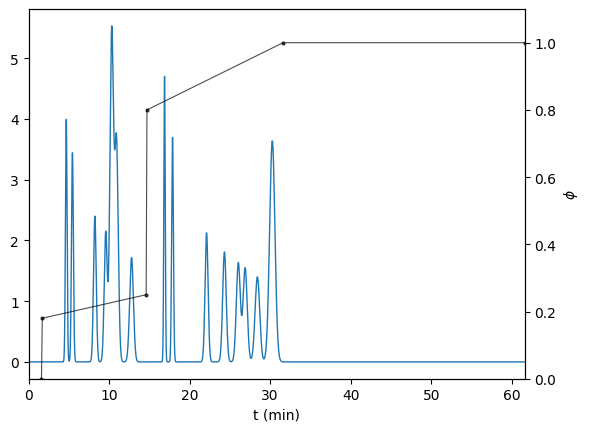

resolution: 12.730314412317586
time: 30.402499679605615


In [82]:
# plot baseline
hplc = HPLC(n_gradients=4)
baseline = pd.Series(
    data = {
        "phi_1": 0.18,
        "phi_2": 0.25,
        "phi_3": 0.8,
        "phi_4": 1.,
        "t_1": 0.1,
        "t_2": 13,
        "t_3": 13.1,
        "t_4": 30.
    }
)
baseline_resolution, baseline_ctime = hplc.plot_chromatogram(baseline)

## Optimization

### Singleobjective Optimization

Here we run a singeobjective optimization in which we want to maximize *just* the resolution. We run 10 campaigns of random sampling, consisting each of 35 samples and again 10 campaigns of BO (GP+qLognei). The first 10 samples of a BO campaign are agains sampled randomly.

#### Random Sampling

In [83]:
def sample(domain):
    datamodel = RandomStrategy(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(10)
    return sampled

def best(domain: Domain, experiments: pd.DataFrame) -> float:
    return experiments.resolution.max()

rresults = []
rresults_alt = []
hplc = HPLC(n_gradients=4)
hplc_alt = HPLC(n_gradients=4)

for i in range(3):
    results = random_results = run(
        hplc,
        strategy_factory=lambda domain: strategies.map(RandomStrategy(domain=hplc.domain)),
        n_iterations=20,
        metric=best,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    rresults.append(results[0])

for i in range(3):
    results = random_results = run(
        hplc_alt,
        strategy_factory=lambda domain: strategies.map(RandomStrategy(domain=hplc_alt.domain)),
        n_iterations=20,
        metric=best,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    rresults_alt.append(results[0])

run 00 with current best 13.010: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.72it/s]


#### Bayesian Optimization

In [84]:
def sample(domain):
    datamodel = RandomStrategy(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(10)
    return sampled

def best(domain: Domain, experiments: pd.DataFrame) -> float:
    return experiments.resolution.max()


sresults = []

for i in range(3):
    results = random_results = run(
        hplc,
        strategy_factory=lambda domain: strategies.map(SoboStrategy(domain=domain)),
        n_iterations=20,
        metric=best,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    sresults.append(results[0])



run 00 with current best 12.918: 100%|██████████████████████████████████████████████████████████████████| 20/20 [02:11<00:00,  6.58s/it]


In [85]:
sresults_alt = []

for i in range(3):
    results = random_results = run(
        hplc_alt,
        strategy_factory=lambda domain: strategies.map(SoboStrategy(domain=domain)),
        n_iterations=20,
        metric=best,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    sresults_alt.append(results[0])

run 00 with current best 14.877: 100%|██████████████████████████████████████████████████████████████████| 20/20 [02:17<00:00,  6.89s/it]


#### Plot the results

Here we plot the results averaged over the 10 independent runs per optimizer (random vs BO). Note that we only show in the graph the results starting from iteration 11 in which we switched in the BO case from random sampling to BO.

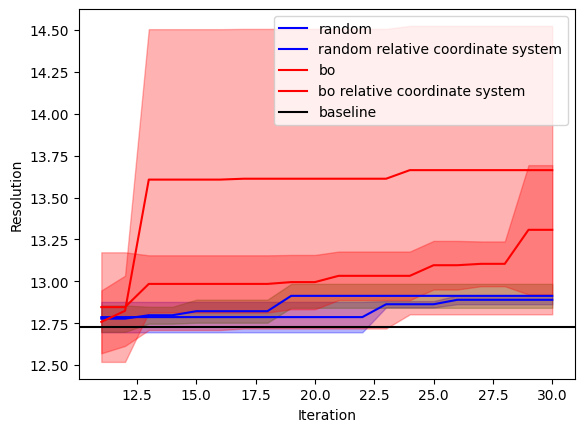

In [88]:
fig, ax = plt.subplots()

best_random = np.array([rresults[i][1] for i in range(len(rresults))])
ax.plot(range(11, 31), best_random.mean(axis=0), color="blue", label="random")
ax.fill_between(range(11, 31),(best_random.mean(0)-best_random.std(0)), (best_random.mean(0)+best_random.std(0)), alpha = 0.3, color = 'blue')

best_random_alt = np.array([rresults_alt[i][1] for i in range(len(rresults_alt))])
ax.plot(range(11, 31), best_random_alt.mean(axis=0), color="blue", label="random relative coordinate system")
ax.fill_between(range(11, 31),(best_random_alt.mean(0)-best_random_alt.std(0)), (best_random_alt.mean(0)+best_random_alt.std(0)), alpha = 0.3, color = 'green')

best_sobo = np.array([sresults[i][1] for i in range(len(sresults))])
ax.plot(range(11, 31), best_sobo.mean(axis=0), color="red", label="bo")
ax.fill_between(range(11, 31),(best_sobo.mean(0)-best_sobo.std(0)), (best_sobo.mean(0)+best_sobo.std(0)), alpha = 0.3, color = 'red')

best_sobo_alt = np.array([sresults_alt[i][1] for i in range(len(sresults_alt))])
ax.plot(range(11, 31), best_sobo_alt.mean(axis=0), color="red", label="bo relative coordinate system")
ax.fill_between(range(11, 31),(best_sobo_alt.mean(0)-best_sobo_alt.std(0)), (best_sobo_alt.mean(0)+best_sobo_alt.std(0)), alpha = 0.3, color = 'red')

ax.axhline(baseline_resolution, color="black", label="baseline")

ax.set_xlabel("Iteration")
ax.set_ylabel("Resolution")
ax.legend()

plt.show()

### Multiobjective Optimization

Here we run a multiobjective optimization in which we want to maximize the resolution and minimize the needed time. We run 10 campaigns of random sampling, consisting each of 35 samples and again 10 campaigns of MOBO (GP+qLognehvi). The first 10 samples of a BO campaign are agains sampled randomly. The reference point is chosen via the workst performance of the original singleobjective random sampling, but BoFire is also able to infer it from the training data, if not provided.

#### Random sampling

In [89]:
ref_point={"resolution": min([i[0].resolution.min() for i in rresults]), "ctime": max([i[0].ctime.max() for i in rresults])}
print(ref_point)


def hypervolume(domain: Domain, experiments: pd.DataFrame) -> float:
    return compute_hypervolume(
        domain, experiments, ref_point=ref_point
    )

def sample(domain):
    datamodel = RandomStrategy(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(10)
    return sampled

mo_rresults = []
mo_rresults_alt = []

for i in range(5):
    results = random_results = run(
        HPLC(n_gradients=4, multiobjective=True),
        strategy_factory=lambda domain: strategies.map(RandomStrategy(domain=domain)),
        n_iterations=20,
        metric=hypervolume,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    mo_rresults.append(results[0])

for i in range(5):
    results = random_results = run(
        HPLC_alt(n_gradients=4, multiobjective=True),
        strategy_factory=lambda domain: strategies.map(RandomStrategy(domain=domain)),
        n_iterations=20,
        metric=hypervolume,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    mo_rresults_alt.append(results[0])

{'resolution': 2.169761970480797, 'ctime': 69.64790168283322}


run 00 with current best 572.034: 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 22.26it/s]


#### Bayesian Optimization

In [ ]:
ref_point={"resolution": min([i[0].resolution.min() for i in rresults]), "ctime": max([i[0].ctime.max() for i in rresults])}

def hypervolume(domain: Domain, experiments: pd.DataFrame) -> float:
    return compute_hypervolume(
        domain, experiments, ref_point=ref_point
    )

def sample(domain):
    datamodel = RandomStrategy(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(10)
    return sampled

mo_sresults = []
mo_rresults = []

for i in range(3):
    results = random_results = run(
        HPLC(n_gradients=4, multiobjective=True),
        strategy_factory=lambda domain: strategies.map(MoboStrategy(domain=domain, ref_point=ref_point)),
        n_iterations=20,
        metric=hypervolume,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    mo_sresults.append(results[0])

for i in range(3):
    results = random_results = run(
        HPLC_alt(n_gradients=4, multiobjective=True),
        strategy_factory=lambda domain: strategies.map(MoboStrategy(domain=domain, ref_point=ref_point)),
        n_iterations=20,
        metric=hypervolume,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    mo_sresults.append(results[0])

run 00 with current best 331.910:  25%|████████████████▌                                                 | 5/20 [01:21<04:12, 16.82s/it]

#### Plot the results
##### Performance Comparison

In [ ]:
fig, ax = plt.subplots()

best_random = np.array([mo_rresults[i][1] for i in range(len(mo_rresults))])
ax.plot(range(11, 31), best_random.mean(axis=0), color="blue", label="random")
ax.fill_between(range(11, 31),(best_random.mean(0)-best_random.std(0)), (best_random.mean(0)+best_random.std(0)), alpha = 0.3, color = 'blue')

best_random = np.array([mo_rresults_alt[i][1] for i in range(len(mo_rresults_alt))])
ax.plot(range(11, 31), best_random.mean(axis=0), color="blue", label="random relative coordinate system")
ax.fill_between(range(11, 31),(best_random.mean(0)-best_random.std(0)), (best_random.mean(0)+best_random.std(0)), alpha = 0.3, color = 'blue')

best_sobo = np.array([mo_sresults[i][1] for i in range(len(mo_sresults))])
ax.plot(range(11, 31),best_sobo.mean(axis=0), color="red", label="bo")
ax.fill_between(range(11, 31),(best_sobo.mean(0)-best_sobo.std(0)), (best_sobo.mean(0)+best_sobo.std(0)), alpha = 0.3, color = 'red')

best_sobo = np.array([mo_sresults_alt[i][1] for i in range(len(mo_sresults_alt))])
ax.plot(range(11, 31),best_sobo.mean(axis=0), color="red", label="bo relative coordinate system")
ax.fill_between(range(11, 31),(best_sobo.mean(0)-best_sobo.std(0)), (best_sobo.mean(0)+best_sobo.std(0)), alpha = 0.3, color = 'red')

ax.set_xlabel("Iteration")
ax.set_ylabel("Hypervolume")
ax.legend()

plt.show()

##### Pareto Front

In [ ]:
optimal = get_pareto_front(HPLC(n_gradients=4, multiobjective=True).domain,pd.concat([mo_rresults[-1][0], mo_sresults[-1][0]],axis=0))

fig, ax = plt.subplots()

ax.scatter(mo_rresults[-1][0].resolution,mo_rresults[-1][0].ctime*-1, color="blue", label="random")
ax.scatter(mo_sresults[-1][0].resolution,mo_sresults[-1][0].ctime*-1, color="red", label="bo")
ax.scatter(baseline_resolution, baseline_ctime*-1, color="green", label="baseline")
ax.scatter(optimal.resolution,optimal.ctime*-1, color="black", marker="x", label="optimal")

ax.legend()

ax.set_xlabel("Resolution")
ax.set_ylabel("Time")

#labels = [i for i in ax.get_yticklabels()]
ax.set_yticks([-70, -60, -50, -40, -30, -20, -10])
ax.set_yticklabels(["70", "60", "50", "40", "30", "20", "10"])

plt.show()

Here we show the six paretooptimal chromatograms together with their gradient profiles.

In [ ]:
for i, row in optimal.sort_values(by="ctime").iterrows():
    hplc.plot_chromatogram(row)